#### News

- QLORA: https://arxiv.org/abs/2305.14314, 
    - Tim Dettmers: https://huggingface.co/timdettmers
    - Guanaco Model Series: https://guanaco-model.github.io/
    - => very large models (65B = 32 bit 200GB, 16 bit 100GB, 8 bit 50 GB, 4bit 25GB) can now run on a 3090 (=24GB), A1600 (=48GB). 


- RWKV: RNN Transformer Models/Raven Models -> https://www.youtube.com/watch?v=x8pW19wKfXQ, https://arxiv.org/pdf/2305.13048.pdf
        
- FalconLM tops Llama Models on OS LLM Leaderboard: https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard, also 7B (!!!) Parameter Models available + Instruction tuned models!

- Finally we know how smart Bard really is: https://chat.lmsys.org/?arena
    - impressive: FastChatT5 3B (!!!) almost Bard performance with 3B parameters

# RNN Language Models

In [1]:
# PREPARE DATA
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

# read words from file
#words = open('./english_verbs.txt', 'r').read().splitlines()
# alternative dataset: https://github.com/dwyl/english-words
#words = open('./words_alpha.txt', 'r').read().splitlines()
# alternative dataset: german names
words = open('./names.txt', 'r').read().splitlines()

print(words[:10])

print('num words: ', len(words)) 

# Prepare Alphabet
## count characters 
dataset_characters = []
for word in words:
    word_characters = list(word) 
    dataset_characters.extend(word_characters)
distinct_characters = sorted(list(set(dataset_characters)))
print('len dictinct characters: ', len(distinct_characters))
print('distinct_characters: ', distinct_characters)

special_characters = ['_'] # changed to blank only for convenience reasons

# ngram characters = distinct characters + start token and end token -> + 2 
num_characters = len(distinct_characters) + len(special_characters)
print('Num Characters: ', num_characters)

# create a character to index mapping because it is easier to work with indices when using tensor matrices -> every character gets assigned an index
character_to_index_map = {character:index for index, character in enumerate(distinct_characters)}
print(character_to_index_map)

# add our special characters that symbolize start and end of a word
character_to_index_map['_'] = 26
print(character_to_index_map)

# write characters into the cells to make it look more nicely
index_to_character_map = {index:character for character, index in character_to_index_map.items()}
print(index_to_character_map)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
num words:  32033
len dictinct characters:  26
distinct_characters:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Num Characters:  27
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '_': 26}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'

In [2]:
# DATA LOADER
context_length = 16

def build_dataset(words):
    X, Y = [], [] # X = inputs, Y = outputs
    for word in words: # [:4] 
        context = [26] * context_length # _ _ _ word _
        for character in word + '_': 
            index = character_to_index_map[character]
            X.append(context)
            Y.append(index)
            #print(''.join(index_to_character_map[i] for i in context), ' -> ', index_to_character_map[index])
            context = context[1:] + [index] # crop first context token and append current token as the new last one of the context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# SPLIT DATA INTO TRAIN, DEV, TEST -> 80%, 10%, 10%
import random
random.shuffle(words)
train_num = int(0.8*len(words))
dev_num = int(0.9*len(words)) - train_num
test_num = len(words) - (train_num + dev_num)
print(train_num)
print(dev_num)
print(test_num)

X_train, Y_train = build_dataset(words[:train_num])
X_dev, Y_dev = build_dataset(words[train_num:train_num+dev_num])
X_test, Y_test = build_dataset(words[train_num+dev_num:])

# SANITY CHECK: 
for x, y in zip(X_train[:20], Y_train[:20]):
    print(''.join(index_to_character_map[ix.item()] for ix in x), '--->', index_to_character_map[y.item()])

25626
3203
3204
torch.Size([182609, 16]) torch.Size([182609])
torch.Size([22748, 16]) torch.Size([22748])
torch.Size([22789, 16]) torch.Size([22789])
________________ ---> u
_______________u ---> r
______________ur ---> i
_____________uri ---> _
________________ ---> k
_______________k ---> o
______________ko ---> n
_____________kon ---> s
____________kons ---> t
___________konst ---> a
__________konsta ---> n
_________konstan ---> t
________konstant ---> i
_______konstanti ---> n
______konstantin ---> e
_____konstantine ---> _
________________ ---> m
_______________m ---> a
______________ma ---> c
_____________mac ---> k


## RNN Networks

![](https://gamedevacademy.org/wp-content/uploads/2017/10/Unrolled-RNN.png.webp)


In [3]:
from torch import nn

class RNNCell(nn.Module):
    def __init__(self, embedding_dim, hidden_dim): 
        super().__init__()
        self.xh_to_h = nn.Linear(embedding_dim + hidden_dim, hidden_dim) # RNN -> GRU, LSTM
        # optional -> per state lm head to classify output

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        ht = F.tanh(self.xh_to_h(xh))
        return ht

In [4]:
class RNN(nn.Module):
    def __init__(self, context_length, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.context_length = context_length
        self.vocab_size = vocab_size
        self.start = nn.Parameter(torch.zeros(1, hidden_dim)) # the starting hidden state
        self.embedding_layer = nn.Embedding(self.vocab_size, embedding_dim) # token embeddings table
        self.cell = RNNCell(embedding_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, self.vocab_size)

    def get_context_length(self):
        return self.context_length  

    def forward(self, idx, targets=None):
        b, t = idx.size()
        
        # embed all the integers up front and all at once for efficiency
        emb = self.embedding_layer(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        hprev = self.start.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        for i in range(t): # Transformer -> T-Layer -> # Residual Connections # Attention?!
            xt = emb[:, i, :] # (b, n_embd)
            ht = self.cell(xt, hprev) # (b, n_embd2)
            hprev = ht
            hiddens.append(ht)

        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)
        
        # take last step logits out for next token prediction objective
        logits = logits[:, -1, :]
        
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets.view(-1), ignore_index=-1)
            
        return logits, loss

In [5]:
# TRAINING
embedding_dim = 10
hidden_dim = 200
vocab_size = num_characters
context_length = 16
learning_rate = 5e-4
weight_decay = 0.01

# define language model
rnn_language_model = RNN(context_length, vocab_size, embedding_dim, hidden_dim)

# define optimizer
optimizer = torch.optim.AdamW(rnn_language_model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99), eps=1e-8)

In [6]:
# TRAIN MODEL
num_epochs = 500
batch_size = 32
learning_rate = 0.01
lossi = []

for i in range(num_epochs):
    # create minibatch
    random_indices = torch.randint(0, X_train.shape[0], (batch_size,)) 
    X_batch, Y_batch = X_train[random_indices], Y_train[random_indices]
    
    # forward pass
    logits, loss = rnn_language_model(X_batch, Y_batch)
    
    # backward pass -> zero out gradients 
    optimizer.zero_grad() # model.zero_grad(set_to_none=True)
    loss.backward()
    
    # update weights -> simple stochastic gradient descent
    optimizer.step()
        
    # logging
    if i % 100 == 0:
        print(f'{i:7d}/{num_epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


      0/    500: 3.3240
    100/    500: 2.6924
    200/    500: 2.5648
    300/    500: 2.7195
    400/    500: 2.6081


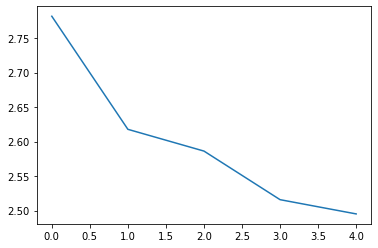

In [7]:
# PLOT training statistics
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [8]:
# EVALUATE MODEL 

@torch.no_grad() # after this decorated gradients are disabled
def split_loss(split, model):
    x, y = {
        'train': (X_train, Y_train), 
        'dev': (X_dev, Y_dev), 
        'test': (X_test, Y_test)
        }[split]
    logits, loss = model(x, y)
    print(split, loss.item())
    
split_loss('train', rnn_language_model)
split_loss('dev', rnn_language_model)
split_loss('test', rnn_language_model)

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


train 2.487360715866089
dev 2.481539249420166
test 2.4903604984283447


In [14]:
# SAMPLING 
num_words_to_sample = 10

for i in range(num_words_to_sample):
    model = rnn_language_model
    out = []
    blank_index = 26 # start with the blank symbol
    context = [blank_index] * context_length 
    while True: 
        # forward pass 
        logits, _ = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from distribution over characters
        index = torch.multinomial(probs, num_samples=1, replacement=True).item()
        # shift context to the right
        context = context[1:] + [index]
        out.append(index_to_character_map[index])
        if index == 26: 
            break 
    print(''.join(out)) 

oheln_
rilidy_
suca_
eubrln_
eritv_
sadhm_
acanne_
noxe_
jlmil_
kycian_


In [ ]:
# Deployment

# libs: mediapipe, dlib

# kivy -> webapp

# docker -> docker auf handy

# webapp -> webassembly 

# kotlin/java -> performance? 

# Unity? + Plugin

# -> decision tree presentation